In [1]:
%env TF_USE_LEGACY_KERAS 1
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
# import keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.optimizers import Adam

from dataset_utils import add_noise

env: TF_USE_LEGACY_KERAS=1


2025-06-09 16:00:09.902002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### GET THE TRAIN/VAL DATA ###
import os

tf.random.set_seed(13)
print("=============================")
train_dir = '/uscms/home/bweiss/nobackup/smart-pixels/dataset_3s_50x12P5_parquets/train_test_3s'
X_train  = pd.read_csv(os.path.join(train_dir, 'FullPrecisionInputTrainSet.csv'))
y_train = pd.read_csv(os.path.join(train_dir, 'TrainSetLabel.csv'))

test_dir = '/uscms/home/bweiss/nobackup/smart-pixels/dataset_2s_50x12P5_parquets/train_test_2s'
X_test  = pd.read_csv(os.path.join(test_dir, 'FullPrecisionInputTestSet.csv'))
y_test = pd.read_csv(os.path.join(test_dir, 'TestSetLabel.csv'))

# print("Run "+str(run_iter)+": Training model for ",sensor_geom," at pT boundary = ",threshold)
# df1 = pd.read_csv('./'+dataset_name+'/FullPrecisionInputTrainSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
# print("Shape of train dataset = ",df1.shape)
# df2 = pd.read_csv('./'+dataset_name+'/TrainSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
# print("Shape of train-label set = ",df2.shape)
# df3 = pd.read_csv('./'+dataset_name+'/FullPrecisionInputTestSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
# print("Shape of test dataset = ",df3.shape)
# df4 = pd.read_csv('./'+dataset_name+'/TestSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
# print("Shape of test-label set = ",df4.shape)
# X_train = df1.values
# X_test = df3.values
# y_train = df2.values
# y_test = df4.values

# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, shuffle=False)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# X_train=add_noise(X_train, 0, 80, integrate=False) 
# X_test=add_noise(X_test, 0, 80, integrate=False) 


# print("X-train, X-test, Y-train, Y-test shapes = ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(14,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 128)               1920      
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,307
Trainable params: 2,307
Non-trainable params: 0
_________________________________________________________________


2025-06-09 16:00:38.704162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-09 16:00:38.780141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-09 16:00:38.780502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-09 16:00:38.782173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=20,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
  62/1562 [>.............................] - ETA: 3s - loss: 0.5306 - sparse_categorical_accuracy: 0.8959

2025-06-09 16:00:40.883106: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1562/1562 [==============================] - 5s 3ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.9637 - val_loss: 0.1302 - val_sparse_categorical_accuracy: 0.9679
Epoch 2/200
1562/1562 [==============================] - 4s 3ms/step - loss: 0.1214 - sparse_categorical_accuracy: 0.9692 - val_loss: 0.1141 - val_sparse_categorical_accuracy: 0.9702
Epoch 3/200
1562/1562 [==============================] - 4s 3ms/step - loss: 0.1105 - sparse_categorical_accuracy: 0.9709 - val_loss: 0.1059 - val_sparse_categorical_accuracy: 0.9716
Epoch 4/200
1562/1562 [==============================] - 4s 3ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.1009 - val_sparse_categorical_accuracy: 0.9725
Epoch 5/200
1562/1562 [==============================] - 4s 3ms/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.0970 - val_sparse_categorical_accuracy: 0.9730
Epoch 6/200
1562/1562 [==============================] - 4s 3ms/step - loss: 0.0959 - sparse_cate

63757/63757 [==============================] - 76s 1ms/step


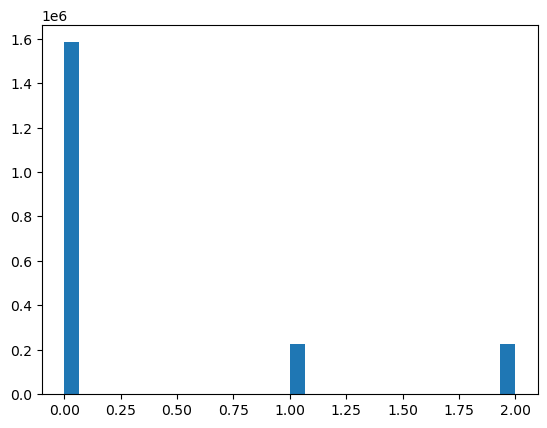

Test loss: 0.364246129989624
Test accuracy: 0.8728835582733154
Confusion matrix:
[[1558623   15795    9505]
 [ 102858  122507    2467]
 [ 127648    1072   99741]]


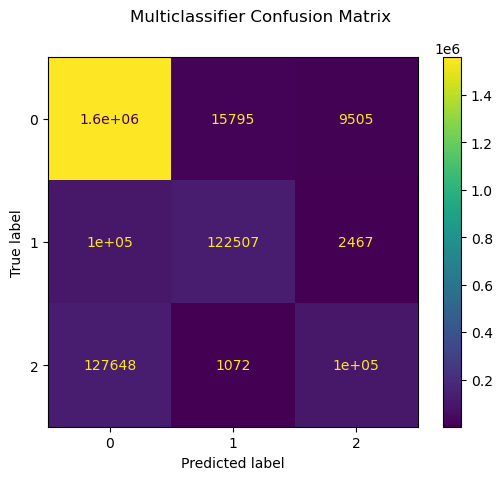

In [5]:
s = 'NoNoise'
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'/Filterloss_{s}.png')
plt.close()

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig(f'./accuracy_{s}.png')
plt.close()
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)
pd.DataFrame(predictionsFiles).to_csv(f"./predictionsFiles_{s}.csv",header='predict', index=False)
pd.DataFrame(y_test).to_csv(f"./testResults_{s}.csv",header='true', index=False)
plt.hist(y_test, bins=30)
plt.show()
plt.close()
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig(f'./confusionMatrix_{s}.png')
plt.show()
plt.close()
model.save_weights(f'./weights/trained_model_{s}_weights.h5')
model.save(f'./weights/trained_mode_{s}.h5')